In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *

import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

run_id = 483

runstat = RunStats.objects.get(pk=run_id)

In [9]:
if runstat.method=="DT":
    ts = DynamicTopic.objects.filter(run_id=run_id)
else:
    ts = Topic.objects.filter(
        run_id=run_id,
        topicarscores__ar=5,
        topicarscores__share__gt=0.005
    )

df = pd.DataFrame.from_dict(
        list(ts.order_by('-ipcc_coverage').values('title','ipcc_coverage'))
)

df.head()

,ipcc_coverage,title
0,0.272609,"{forc, aerosol, radiat}"
1,0.262075,"{scenario, project, futur}"
2,0.249085,"{ozon, stratospher, tropospher}"
3,0.241629,"{adapt, capac, local}"
4,0.239184,"{cloud, radiat, feedback}"


0.125032881545
0.125032881545


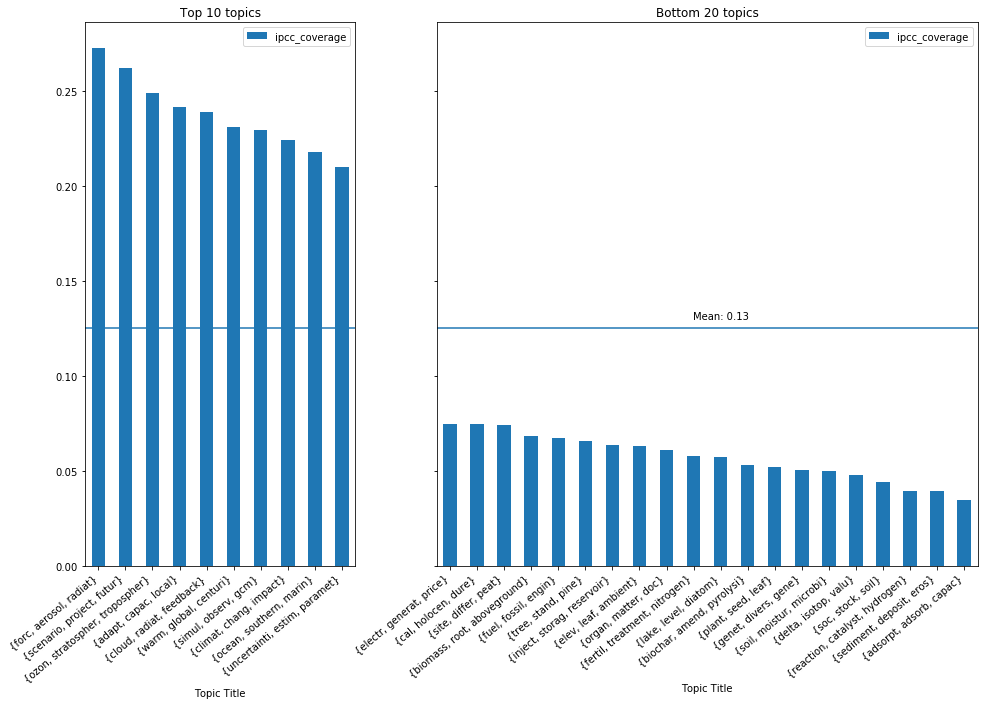

In [3]:
plt.rcParams["figure.figsize"] = [16,10]

# plot it
fig = plt.figure(figsize=(16, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)

axs = [ax0,ax1]

nn = 15


i=0
for ax in axs:

    bdf = df.set_index(['title'])[['ipcc_coverage']]
    
    print(bdf['ipcc_coverage'].mean())

    m = bdf['ipcc_coverage'].mean()
    
    #ax.set_ylim([0, 20])
    
    if i==0:
        n = nn-5
        bdf.head(n).plot.bar(ax=ax)
        ax.set_title('Top {} topics'.format(n))
    else:
        n = nn+5
        bdf.tail(n).plot.bar(ax=ax)
        ax.set_title('Bottom {} topics'.format(n))
        ax.text(n/2,m*1.05,"Mean: {}".format(round(m,2)),ha="center",va="center")
    ax.axhline(y=m)
        
    i+=1
    
    ax.set_xlabel('Topic Title')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
plt.xlabel('Topic Title')

plt.savefig('../plots/ipcc_topics_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [10]:
df = pd.DataFrame.from_dict(
        list(ts.order_by('-ipcc_coverage').values('title','ipcc_coverage','primary_wg','wg_1','wg_2','wg_3'))
)

df.head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3
0,0.272609,1,"{forc, aerosol, radiat}",0.879340,0.057690,0.062970
1,0.262075,2,"{scenario, project, futur}",0.233040,0.649121,0.117839
2,0.249085,1,"{ozon, stratospher, tropospher}",0.765632,0.207285,0.027083
3,0.241629,2,"{adapt, capac, local}",0.011092,0.973399,0.015509
4,0.239184,1,"{cloud, radiat, feedback}",0.955766,0.029274,0.014960


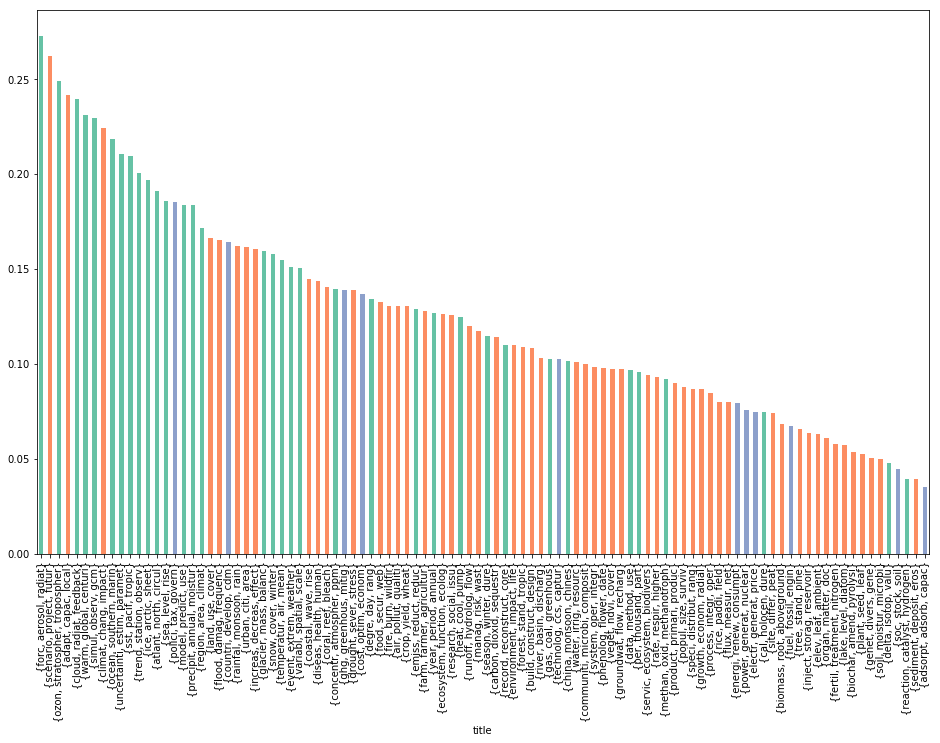

In [5]:
plt.rcParams["figure.figsize"] = [16,10]

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

bdf = df.set_index(['title'])

bdf['ipcc_coverage'].plot(kind='bar', color=[colors[i] for i in bdf['primary_wg']])

plt.show()

In [ ]:
soil_tops = Topic.objects.filter(
    topicterm__run_id=run_id,
    topicterm__term__title="soil"
)
print(soil_tops.count())

soil_tops

In [14]:
mixtures = ts.order_by('-ipcc_coverage').values('title','primary_wg','wg_1','wg_2','wg_3','ipcc_coverage')

df = pd.DataFrame.from_dict(list(mixtures))
df['WG 1'] = df['ipcc_coverage'] * df['wg_1']
df['WG 2'] = df['ipcc_coverage'] * df['wg_2']
df['WG 3'] = df['ipcc_coverage'] * df['wg_3']


df.head(20)

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3
0,0.272609,1,"{forc, aerosol, radiat}",0.879340,0.057690,0.062970,0.239716,0.015727,0.017166
1,0.262075,2,"{scenario, project, futur}",0.233040,0.649121,0.117839,0.061074,0.170118,0.030883
2,0.249085,1,"{ozon, stratospher, tropospher}",0.765632,0.207285,0.027083,0.190707,0.051632,0.006746
3,0.241629,2,"{adapt, capac, local}",0.011092,0.973399,0.015509,0.002680,0.235201,0.003747
4,0.239184,1,"{cloud, radiat, feedback}",0.955766,0.029274,0.014960,0.228604,0.007002,0.003578
5,0.230992,1,"{warm, global, centuri}",0.508861,0.406938,0.084201,0.117543,0.093999,0.019450
6,0.229376,1,"{simul, observ, gcm}",0.697001,0.263675,0.039324,0.159876,0.060481,0.009020
7,0.224353,2,"{climat, chang, impact}",0.173863,0.750928,0.075209,0.039007,0.168473,0.016873
8,0.218135,1,"{ocean, southern, marin}",0.749482,0.208534,0.041983,0.163488,0.045489,0.009158
9,0.210213,1,"{uncertainti, estim, paramet}",0.516789,0.336792,0.146419,0.108636,0.070798,0.030779


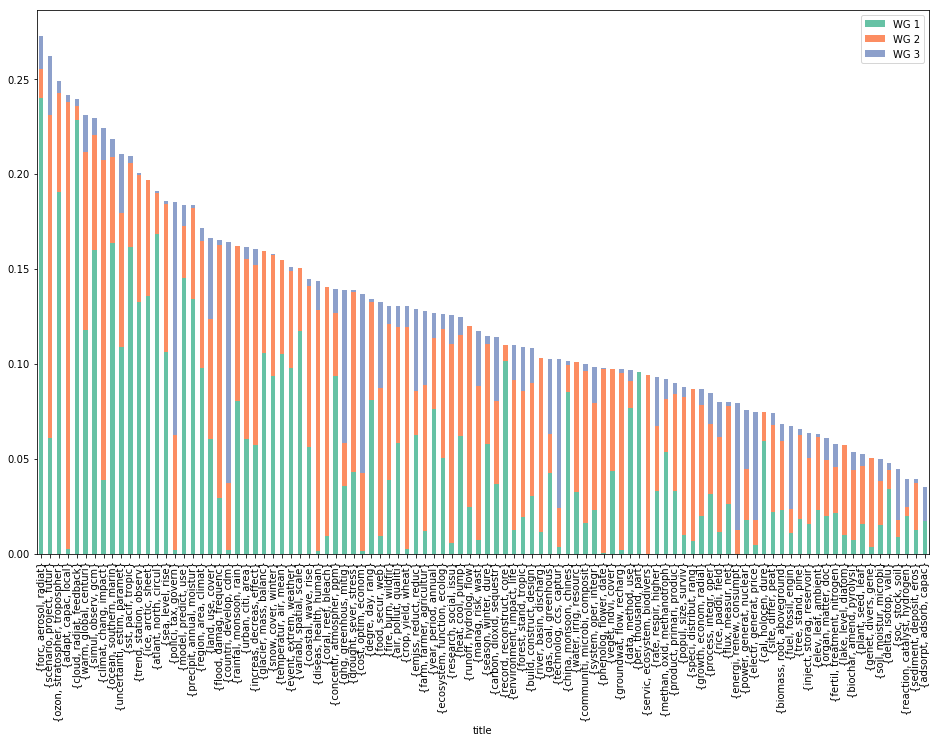

In [15]:
plt.rcParams["figure.figsize"] = [16,10]

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

colors = ["#66c2a5","#fc8d62","#8da0cb"]

bdf = df.set_index(['title'])

#bdf['ipcc_coverage'].plot(kind='bar', color=[colors[i] for i in bdf['primary_wg']])

bdf[['WG 1','WG 2','WG 3']].plot(kind='bar', stacked=True, color = colors)

plt.savefig('../plots/ipcc_topics_wg_{}.png'.format(run_id),bbox_inches='tight')   


plt.show()

In [17]:
df['wg1_3'] = df['wg_1'] * df['wg_3']
df['wg1_2'] = df['wg_1'] * df['wg_2']
df['wg2_3'] = df['wg_2'] * df['wg_3']

df.sort_values('wg1_3',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
99,0.034882,3,"{adsorpt, adsorb, capac}",0.498055,0.000000,0.501945,0.017373,0.000000,0.017509,0.249996,0.000000,0.000000
97,0.039565,1,"{reaction, catalyst, hydrogen}",0.507437,0.113581,0.378982,0.020077,0.004494,0.014994,0.192309,0.057635,0.043045
42,0.128814,1,"{emiss, reduct, reduc}",0.483401,0.181409,0.335189,0.062269,0.023368,0.043177,0.162031,0.087694,0.060806
57,0.102761,1,"{gas, coal, greenhous}",0.413438,0.199738,0.386824,0.042486,0.020525,0.039751,0.159928,0.082579,0.077263
34,0.139004,3,"{ghg, greenhous, mitig}",0.257943,0.161895,0.580162,0.035855,0.022504,0.080645,0.149649,0.041760,0.093925


In [18]:
df.sort_values('wg1_2',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
22,0.162019,2,"{rainfal, monsoon, rain}",0.496097,0.503620,0.000283,0.080377,0.081596,0.000046,0.000141,0.249844,0.000143
64,0.097442,2,"{veget, ndvi, cover}",0.448473,0.551527,0.000000,0.043700,0.053742,0.000000,0.000000,0.247345,0.000000
26,0.157682,1,"{snow, cover, winter}",0.592469,0.406428,0.001103,0.093422,0.064086,0.000174,0.000654,0.240796,0.000448
14,0.185595,1,"{sea, level, rise}",0.572816,0.418009,0.009175,0.106311,0.077580,0.001703,0.005255,0.239442,0.003835
37,0.133986,1,"{degre, day, rang}",0.605329,0.384235,0.010436,0.081106,0.051482,0.001398,0.006317,0.232588,0.004010


In [19]:
df.sort_values('wg2_3',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
15,0.185375,3,"{polici, tax, govern}",0.010030,0.326666,0.663304,0.001859,0.060556,0.122960,0.006653,0.003276,0.216679
36,0.136752,3,"{cost, optim, econom}",0.010409,0.301765,0.687826,0.001423,0.041267,0.094061,0.007160,0.003141,0.207562
38,0.132414,2,"{food, secur, web}",0.069767,0.589101,0.341132,0.009238,0.078005,0.045171,0.023800,0.041100,0.200961
43,0.127902,2,"{farm, farmer, agricultur}",0.094589,0.598587,0.306824,0.012098,0.076560,0.039243,0.029022,0.056620,0.183661
49,0.117114,2,"{manag, risk, wast}",0.061127,0.692414,0.246459,0.007159,0.081092,0.028864,0.015065,0.042325,0.170652


In [20]:
pd.options.display.float_format = '{:.2f}%'.format

tabdf = df[['ipcc_coverage','primary_wg','title','wg_1','wg_2','wg_3','wg1_2','wg1_3','wg2_3']]

tabdf = tabdf.rename(columns={
    'ipcc_coverage':'IPCC Coverage','primary_wg':'Primary WG','title':'Topic Title',
    'wg_1':'WG 1','wg_2': 'WG 2','wg_3': 'WG 3'
})

cformat = 'p{1.4cm} p{1cm} l r r r'

tabdf = tabdf.sort_values('wg1_2',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_1_2.tex'.format(run_id),column_format=cformat,index=False)

tabdf = tabdf.sort_values('wg1_3',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_1_3.tex'.format(run_id),column_format=cformat,index=False)

tabdf = tabdf.sort_values('wg2_3',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_2_3.tex'.format(run_id),column_format=cformat,index=False)



ttabdf.head()


,IPCC Coverage,Primary WG,Topic Title,WG 1,WG 2,WG 3
15,0.19%,3,"{polici, tax, govern}",0.01%,0.33%,0.66%
36,0.14%,3,"{cost, optim, econom}",0.01%,0.30%,0.69%
38,0.13%,2,"{food, secur, web}",0.07%,0.59%,0.34%
43,0.13%,2,"{farm, farmer, agricultur}",0.09%,0.60%,0.31%
49,0.12%,2,"{manag, risk, wast}",0.06%,0.69%,0.25%


In [ ]:
ipccdocs = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('topic__title','doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    score=Sum('score'),
    count=Count('doc',distinct=True)
)
ipdf_tops =  pd.DataFrame.from_dict(list(ipccdocs)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
#ipdf.head()

In [ ]:
wgtcounts = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    wgt_score=Sum('score'),
    wgt_count=Count('doc',distinct=True)
)
wgtc =  pd.DataFrame.from_dict(list(wgtcounts)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
wgtc.head()

In [ ]:
wgcounts = IPCCRef.objects.all().values('ar','wg__wg').annotate(
    wg_count=Count('pk',distinct=True)
)
wgc =  pd.DataFrame.from_dict(list(wgcounts)).rename(columns={'ar':'AR','wg__wg':'WG'})
wgc.head(15)

In [ ]:
ipdf = ipdf_tops.merge(wgc).merge(wgtc)
ipdf.head()

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=True
)

grouped = ipdf.groupby('WG')

targets = zip(grouped.groups.keys(), axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('WG {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=1,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf[ipdf['WG']==3].groupby('AR')

targets = zip(range(2,6), axs.flatten())

n = 25

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf.dropna().sort_values(['AR','WG']).groupby(['AR','WG'])

arorder = []
for x in range(2,6):
    for y in range(1,4):
        arorder.append((float(x),float(y)))

targets = zip(arorder, axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} WG {:.0f} topics'.format(key[0],key[1]))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_xlabel('Topic Title')
    text = "{} out of {} references".format(group['wgt_count'][0],group['wg_count'][0])
    ax.text(n-1,8,text,ha="right")

plt.tight_layout()

plt.savefig('../plots/ipcc_topics_ars_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

plt.show()

In [ ]:
wg3 = ipdf[ipdf['WG']==3].dropna().sort_values(['AR','WG'])

wg3['share'] = wg3['score'] / wg3['wgt_score']*100

wg3 = wg3[wg3['share']>2]

wg3 = wg3[wg3['AR']>1]

wg3 = pd.pivot_table(
                wg3,
                values='share',
                index='AR',
                columns='topic__title'
            )
wg3.head()

fig, ax = plt.subplots()

#ax = enumerate(axs)[0]

wg3.plot.bar(stacked=True,ax=ax)

handles, labels = ax.get_legend_handles_labels()

lpos = (1.1,0.75)

ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)

plt.show()

In [ ]:
wgs = [
    {"WG":1, "score": 0},
    {"WG":2, "score": 0},
    {"WG":3, "score": 0}
]
for topic in Topic.objects.filter(run_id=run_id):
    tdocs = Doc.objects.filter(doctopic__topic=topic,doctopic__score__gt=runstat.dthreshold)
    for wg in wgs:
        wgdocs = tdocs.filter(ipccref__wg__wg=wg["WG"])
        if wgdocs.count() == 0:
            wg['score'] = 0
        else:
            wg['score'] = wgdocs.aggregate(s = Sum('doctopic__score'))['s']       
    maxwg =  max(wgs, key=lambda x:x['score'])
    tscore = sum(x['score'] for x in wgs)
    if tscore==0:
        tscore=1
    topic.wg_1 = wgs[0]['score'] / tscore
    topic.wg_2 = wgs[1]['score'] / tscore
    topic.wg_3 = wgs[2]['score'] / tscore
    topic.primary_wg = maxwg['WG']
    topic.wg_prop = maxwg['score'] / tscore
    topic.save()

In [ ]:
wgdts = DocTopic.objects.filter(topic__run_id=run_id).values('doc__PY','topic__title').annotate(
    score = Sum('score')
)


wgpy = pd.DataFrame.from_dict(list(wgdts.values('topic__title','score','doc__PY','topic__wg_1','topic__wg_2','topic__wg_3')))

wgpy.head()

In [ ]:
wgpy_dict = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        wgpy_dict.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

wgpy = pd.DataFrame.from_dict(wgpy_dict)

wgpy.head()

wgpy_wide = pd.pivot_table(
    data=wgpy,
    index='PY',
    columns='WG',
    values='score'
)

wgpy_wide.head()

wgpy_wide.plot()

plt.show()




In [ ]:
tword = "biochar"

sus = Topic.objects.filter(run_id=run_id,title__icontains=tword)

print(sus.count())

sus_scores = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py,topic__in=sus):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        sus_scores.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })
sus_df = pd.DataFrame.from_dict(sus_scores)

sus_wide = pd.pivot_table(
    data=sus_df,
    index='PY',
    columns='WG',
    values='score'
)

sus_wide.plot()

plt.title(tword)

plt.show()


In [ ]:
iprs = Doc.objects.filter(ipccref__isnull=False).values('PY','ipccref__wg__wg').annotate(
    n = Count('UT')
)

ippy = pd.DataFrame.from_dict(list(iprs))

ippy_wide = pd.pivot_table(
    data=ippy,
    index='PY',
    columns='ipccref__wg__wg',
    values='n'
)


ippy_wide.plot()

plt.show()

In [ ]:
tcs = TopicCorr.objects.filter(run_id=run_id).filter(score__gt=0.05,score__lt=1).annotate(
        source=F('topic'),
        target=F('topiccorr')
    )



tcdf = pd.DataFrame.from_dict(list(tcs.values('topic','topiccorr','topic__primary_wg','topiccorr__primary_wg','score')))

def issame(x):
    if x['topic__primary_wg']==x['topiccorr__primary_wg']:
        return 1
    else:
        return 0

tcdf['samewg'] = tcdf.apply(lambda x: issame(x) ,axis=1)

tcdf.head()

In [ ]:
result = sm.ols(formula="score ~ samewg + topic__primary_wg", data=tcdf).fit()

print(result.summary())

In [ ]:
X1, X2 = np.arange(10,21), np.arange(20,26.5,.5)

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print(cm.tconfint_diff(usevar='unequal'))

In [ ]:
from scipy.stats import ttest_ind

cat1 = tcdf[tcdf['samewg']==1]
cat2 = tcdf[tcdf['samewg']==0]


ttest_ind(cat1['score'], cat2['score'])

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]

gp = tcdf[['score','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()


In [ ]:
dts = DocTopic.objects.filter(run_id=run_id)

df = pd.DataFrame(list(dts.values('doc_id','topic_id','score')))

df = df.pivot(index='doc_id',columns='topic_id',values='score').fillna(0)

corr = df.corr()

corr['topic1'] = corr.index


In [ ]:
topics = Topic.objects.filter(run_id=run_id)
tdf = pd.DataFrame.from_dict(list(topics.values('id','primary_wg')))


tdf.head()

In [ ]:
corrlong = pd.melt(corr,id_vars=['topic1'])
corrlong = corrlong[corrlong['value']<1]

mask = corrlong['topic1'] < corrlong['topic_id']

corrlong['first'] = corrlong['topic1'].where(mask, corrlong['topic_id'])
corrlong['second'] = corrlong['topic_id'].where(mask, corrlong['topic1'])

corrlong = corrlong.drop_duplicates(subset=['value', 'first', 'second'])[['topic1','topic_id','value']].rename(columns={
    'topic1':'topic1','topic_id':'topic2'
})

tdf1 = tdf.rename(columns={
    'id':'topic1',
    'primary_wg': 'wg_1'
})

tdf2 = tdf.rename(columns={
    'id':'topic2',
    'primary_wg': 'wg_2'
})

corrlong = corrlong.merge(tdf1).merge(tdf2)

def issame(x):
    if x['wg_1']==x['wg_2']:
        return 1
    else:
        return 0

corrlong['samewg'] = corrlong.apply(lambda x: issame(x) ,axis=1)


corrlong.head()

In [ ]:
gp = corrlong[['value','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()

In [ ]:
from scipy.stats import ttest_ind

cat1 = corrlong[corrlong['samewg']==1]
cat2 = corrlong[corrlong['samewg']==0]


ttest_ind(cat1['value'], cat2['value'])